In [ ]:
# Import libraries
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import celltypist
from celltypist import models
import scipy.sparse as sp
from scipy.spatial.distance import cdist
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

In [2]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

import numba
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning

warnings.simplefilter("ignore", category=NumbaDeprecationWarning)

# Load The Data and Make Pseudobulk Dataset

In [ ]:
adata_fallopian = sc.read_h5ad(
    "data/fallopian_clusters.h5ad"
)
adata_ovary = sc.read_h5ad(
    "data/ovary_clusters.h5ad"
)

In [4]:
adata_fallopian_normal = adata_fallopian[
    ~pd.isna(adata_fallopian.obs["final_cell_annotation"])
].copy()
adata_fallopian_normal.obs["final_cell_annotation"].unique()

['36_Fallopian Tube Normal_ciliated epithelial ..., '19_Fallopian Tube Normal_secretory cell', '10_Fallopian Tube Normal_smooth muscle cell', '3_Fallopian Tube Normal_smooth muscle cell']
Categories (4, object): ['3_Fallopian Tube Normal_smooth muscle cell', '10_Fallopian Tube Normal_smooth muscle cell', '19_Fallopian Tube Normal_secretory cell', '36_Fallopian Tube Normal_ciliated epithelial ...]

In [5]:
adata_ovary_normal = adata_ovary[
    ~pd.isna(adata_ovary.obs["final_cell_annotation"])
].copy()
adata_ovary_normal.obs["final_cell_annotation"].unique()

['3_Ovary Normal_eHormones', '2_Ovary Normal_MUC5B', '10_Ovary Normal_eHormones', '0_Ovary Normal_eHormones', '12_Ovary Normal_Immune_Myeloid', '31_Ovary Normal_KRT5', '88_Ovary Normal_eStromal', '34_Ovary Normal_eHormones']
Categories (8, object): ['0_Ovary Normal_eHormones', '2_Ovary Normal_MUC5B', '3_Ovary Normal_eHormones', '10_Ovary Normal_eHormones', '12_Ovary Normal_Immune_Myeloid', '31_Ovary Normal_KRT5', '34_Ovary Normal_eHormones', '88_Ovary Normal_eStromal']

In [6]:
mask = (adata_ovary.obs["Organ_origin"] == "Ovary") & (
    adata_ovary.obs["cnv_status"] == "tumor"
)
adata_cancer = adata_ovary[mask].copy()
adata_cancer.obs

,Dataset,Organ_origin,Sample,Patient,Tissue,Cancer type,cnv_status,Celltype,dataset,clusters,final_cell_annotation
pan_bluprint_ovary_BT1303_AAACGGGCAAGGACTG,ov_pan_blueprint_ovary,Ovary,pan_blueprint_ovary_BT1303,pan_blueprint_ovary_11,Tumor,OV,tumor,Epithelial,12,3,NaN
pan_bluprint_ovary_BT1303_AACTCCCAGGCACATG,ov_pan_blueprint_ovary,Ovary,pan_blueprint_ovary_BT1303,pan_blueprint_ovary_11,Tumor,OV,tumor,Epithelial,12,3,NaN
pan_bluprint_ovary_BT1303_AACTGGTAGGAGTAGA,ov_pan_blueprint_ovary,Ovary,pan_blueprint_ovary_BT1303,pan_blueprint_ovary_11,Tumor,OV,tumor,Epithelial,12,3,NaN
pan_bluprint_ovary_BT1303_ACTGATGAGGTCATCT,ov_pan_blueprint_ovary,Ovary,pan_blueprint_ovary_BT1303,pan_blueprint_ovary_11,Tumor,OV,tumor,Epithelial,12,3,NaN
pan_bluprint_ovary_BT1303_AGGGTGACATGTCTCC,ov_pan_blueprint_ovary,Ovary,pan_blueprint_ovary_BT1303,pan_blueprint_ovary_11,Tumor,OV,tumor,Epithelial,12,3,NaN
...,...,...,...,...,...,...,...,...,...,...,...
pan_blue_hgstoc_TTTGCGCCACATGGGA_SOL012,ov_hgstoc_pan_blueprint_ovary,Ovary,pan_blue_hgstoc_SOL012,pan_blue_hgstoc_P6,Tumor,OV,tumor,Epithelial,85,34,NaN
pan_blue_hgstoc_TTTGCGCTCCTGTAGA_SOL012,ov_hgstoc_pan_blueprint_ovary,Ovary,pan_blue_hgstoc_SOL012,pan_blue_hgstoc_P6,Tumor,OV,tumor,Epithelial,85,34,NaN
pan_blue_hgstoc_TTTGTCACAAAGCAAT_SOL012,ov_hgstoc_pan_blueprint_ovary,Ovary,pan_blue_hgstoc_SOL012,pan_blue_hgstoc_P6,Tumor,OV,tumor,Epithelial,85,34,NaN
pan_GSE140819_GSM4186989_HTAPP-316-SMP-991_TST_channel1_CAGCAGCAGCTGTTCA-1,pan_GSE140819,Ovary,GSM4186989_HTAPP-316-SMP-991_TST_channel1,pan_GSE140819_HTAPP-316-SMP-991,Tumor,OV,tumor,Epithelial,101,3,NaN


In [7]:
adata_cancer.obs["final_cell_annotation"] = "Cancer"
adata_cancer.obs

,Dataset,Organ_origin,Sample,Patient,Tissue,Cancer type,cnv_status,Celltype,dataset,clusters,final_cell_annotation
pan_bluprint_ovary_BT1303_AAACGGGCAAGGACTG,ov_pan_blueprint_ovary,Ovary,pan_blueprint_ovary_BT1303,pan_blueprint_ovary_11,Tumor,OV,tumor,Epithelial,12,3,Cancer
pan_bluprint_ovary_BT1303_AACTCCCAGGCACATG,ov_pan_blueprint_ovary,Ovary,pan_blueprint_ovary_BT1303,pan_blueprint_ovary_11,Tumor,OV,tumor,Epithelial,12,3,Cancer
pan_bluprint_ovary_BT1303_AACTGGTAGGAGTAGA,ov_pan_blueprint_ovary,Ovary,pan_blueprint_ovary_BT1303,pan_blueprint_ovary_11,Tumor,OV,tumor,Epithelial,12,3,Cancer
pan_bluprint_ovary_BT1303_ACTGATGAGGTCATCT,ov_pan_blueprint_ovary,Ovary,pan_blueprint_ovary_BT1303,pan_blueprint_ovary_11,Tumor,OV,tumor,Epithelial,12,3,Cancer
pan_bluprint_ovary_BT1303_AGGGTGACATGTCTCC,ov_pan_blueprint_ovary,Ovary,pan_blueprint_ovary_BT1303,pan_blueprint_ovary_11,Tumor,OV,tumor,Epithelial,12,3,Cancer
...,...,...,...,...,...,...,...,...,...,...,...
pan_blue_hgstoc_TTTGCGCCACATGGGA_SOL012,ov_hgstoc_pan_blueprint_ovary,Ovary,pan_blue_hgstoc_SOL012,pan_blue_hgstoc_P6,Tumor,OV,tumor,Epithelial,85,34,Cancer
pan_blue_hgstoc_TTTGCGCTCCTGTAGA_SOL012,ov_hgstoc_pan_blueprint_ovary,Ovary,pan_blue_hgstoc_SOL012,pan_blue_hgstoc_P6,Tumor,OV,tumor,Epithelial,85,34,Cancer
pan_blue_hgstoc_TTTGTCACAAAGCAAT_SOL012,ov_hgstoc_pan_blueprint_ovary,Ovary,pan_blue_hgstoc_SOL012,pan_blue_hgstoc_P6,Tumor,OV,tumor,Epithelial,85,34,Cancer
pan_GSE140819_GSM4186989_HTAPP-316-SMP-991_TST_channel1_CAGCAGCAGCTGTTCA-1,pan_GSE140819,Ovary,GSM4186989_HTAPP-316-SMP-991_TST_channel1,pan_GSE140819_HTAPP-316-SMP-991,Tumor,OV,tumor,Epithelial,101,3,Cancer


In [8]:
adata_ovary_fallopian = ad.concat(
    [adata_fallopian_normal, adata_ovary_normal, adata_cancer]
)
adata_ovary_fallopian.obs

,Dataset,Organ_origin,Sample,Patient,Tissue,Cancer type,cnv_status,Celltype,dataset,clusters,final_cell_annotation
fallopian_tube_GSE151214_GSM4568681_AAACCTGAGCCAGTTT-1,fallopian_tube_GSE151214,Fallopian Tube,GSM4568681,fallopian_tube_GSE151214_GSM4568681,Normal,Fallopian Tube Normal,normal,Epithelial,23,36,36_Fallopian Tube Normal_ciliated epithelial cell
fallopian_tube_GSE151214_GSM4568681_AAACCTGGTCTCACCT-1,fallopian_tube_GSE151214,Fallopian Tube,GSM4568681,fallopian_tube_GSE151214_GSM4568681,Normal,Fallopian Tube Normal,normal,Epithelial,23,36,36_Fallopian Tube Normal_ciliated epithelial cell
fallopian_tube_GSE151214_GSM4568681_AAACCTGGTGGGTATG-1,fallopian_tube_GSE151214,Fallopian Tube,GSM4568681,fallopian_tube_GSE151214_GSM4568681,Normal,Fallopian Tube Normal,normal,Epithelial,23,36,36_Fallopian Tube Normal_ciliated epithelial cell
fallopian_tube_GSE151214_GSM4568681_AAACGGGGTAACGACG-1,fallopian_tube_GSE151214,Fallopian Tube,GSM4568681,fallopian_tube_GSE151214_GSM4568681,Normal,Fallopian Tube Normal,normal,Epithelial,23,19,19_Fallopian Tube Normal_secretory cell
fallopian_tube_GSE151214_GSM4568681_AAACGGGGTCTCATCC-1,fallopian_tube_GSE151214,Fallopian Tube,GSM4568681,fallopian_tube_GSE151214_GSM4568681,Normal,Fallopian Tube Normal,normal,Epithelial,23,36,36_Fallopian Tube Normal_ciliated epithelial cell
...,...,...,...,...,...,...,...,...,...,...,...
pan_blue_hgstoc_TTTGCGCCACATGGGA_SOL012,ov_hgstoc_pan_blueprint_ovary,Ovary,pan_blue_hgstoc_SOL012,pan_blue_hgstoc_P6,Tumor,OV,tumor,Epithelial,85,34,Cancer
pan_blue_hgstoc_TTTGCGCTCCTGTAGA_SOL012,ov_hgstoc_pan_blueprint_ovary,Ovary,pan_blue_hgstoc_SOL012,pan_blue_hgstoc_P6,Tumor,OV,tumor,Epithelial,85,34,Cancer
pan_blue_hgstoc_TTTGTCACAAAGCAAT_SOL012,ov_hgstoc_pan_blueprint_ovary,Ovary,pan_blue_hgstoc_SOL012,pan_blue_hgstoc_P6,Tumor,OV,tumor,Epithelial,85,34,Cancer
pan_GSE140819_GSM4186989_HTAPP-316-SMP-991_TST_channel1_CAGCAGCAGCTGTTCA-1,pan_GSE140819,Ovary,GSM4186989_HTAPP-316-SMP-991_TST_channel1,pan_GSE140819_HTAPP-316-SMP-991,Tumor,OV,tumor,Epithelial,101,3,Cancer


In [9]:
print(adata_ovary_fallopian.obs["final_cell_annotation"].value_counts())

final_cell_annotation
Cancer                                               11939
36_Fallopian Tube Normal_ciliated epithelial cell     5524
3_Ovary Normal_eHormones                              3424
19_Fallopian Tube Normal_secretory cell               2824
88_Ovary Normal_eStromal                              1536
10_Ovary Normal_eHormones                              313
0_Ovary Normal_eHormones                               165
3_Fallopian Tube Normal_smooth muscle cell             146
10_Fallopian Tube Normal_smooth muscle cell            102
2_Ovary Normal_MUC5B                                    74
12_Ovary Normal_Immune_Myeloid                          71
31_Ovary Normal_KRT5                                    65
34_Ovary Normal_eHormones                               60
Name: count, dtype: int64


In [10]:
adata_ovary_fallopian.obs["final_cell_annotation"] = adata_ovary_fallopian.obs[
    "final_cell_annotation"
].str.replace(r"^\d+_", "", regex=True)

In [11]:
print(adata_ovary_fallopian.obs["final_cell_annotation"].value_counts())

final_cell_annotation
Cancer                                            11939
Fallopian Tube Normal_ciliated epithelial cell     5524
Ovary Normal_eHormones                             3962
Fallopian Tube Normal_secretory cell               2824
Ovary Normal_eStromal                              1536
Fallopian Tube Normal_smooth muscle cell            248
Ovary Normal_MUC5B                                   74
Ovary Normal_Immune_Myeloid                          71
Ovary Normal_KRT5                                    65
Name: count, dtype: int64


In [13]:
# Count number of cells per sample
sample_counts = adata_ovary_fallopian.obs["Sample"].value_counts()

# Identify samples with at least 100 cells (minimum threshold)
valid_samples = sample_counts[sample_counts >= 100].index

# Filter dataset to keep only valid samples (>=100 cells)
adata_ovary_fallopian = adata_ovary_fallopian[
    adata_ovary_fallopian.obs["Sample"].isin(valid_samples)
].copy()

In [14]:
# Create a copy of the original data to preserve raw counts
adata_pseudo = adata_ovary_fallopian.copy()

# Initialize list to store pseudobulk samples
pbs = []

# Reverse log1p transformation to return to raw counts
if sp.issparse(adata_pseudo.X):
    adata_pseudo.X.data = np.expm1(
        adata_pseudo.X.data
    )  # Apply to nonzero elements only
else:
    adata_pseudo.X = np.expm1(adata_pseudo.X)  # Apply to dense matrix

# Generate pseudobulk profiles by (sample, cell type) groups
for (sample, cell_type), samp_cell_subset in adata_pseudo.obs.groupby(
    ["Sample", "final_cell_annotation"]
):
    sample_cell_sum = samp_cell_subset.shape[0]

    if sample_cell_sum > 100:  # Apply minimum cell count filter (100 cells per group)
        subset_adata = adata_pseudo[samp_cell_subset.index]

        # Sum the expression
        rep_data = sc.AnnData(
            X=subset_adata.X.sum(axis=0), var=subset_adata.var
        )  # Save the gene annotation

        # Matadata
        rep_data.obs_names = [f"{sample}_{cell_type}"]  # Name = Sample_CellType
        rep_data.obs["Sample"] = sample
        rep_data.obs["final_cell_annotation"] = cell_type
        rep_data.obs["dataset"] = subset_adata.obs["Dataset"].iloc[0]
        rep_data.obs["cnv_status"] = subset_adata.obs["cnv_status"].iloc[0]

        pbs.append(rep_data)

# Combine all pseudobulk samples into single AnnData object
adata_pseudobulk = sc.concat(pbs)

In [15]:
adata_pseudobulk.X.shape

(41, 36601)

In [16]:
adata_pseudobulk_normalized_log = adata_pseudobulk.copy()

# PCA, PCoA and UMAP Visualization

In [ ]:
# PCA and UMAP
sc.pp.normalize_total(adata_pseudobulk, target_sum=1e4)  # Normalization
print(adata_pseudobulk.X.sum(axis=1))

[10000.001  9999.999 10000.     9999.999 10000.001 10000.    10000.
  9999.999 10000.    10000.001 10000.     9999.999 10000.    10000.
 10000.    10000.    10000.     9999.999 10000.    10000.    10000.
 10000.    10000.001  9999.999 10000.    10000.001 10000.    10000.
 10000.     9999.999 10000.    10000.    10000.    10000.    10000.
  9999.999  9999.999  9999.999 10000.     9999.999 10000.   ]


In [18]:
sc.pp.normalize_total(adata_pseudobulk_normalized_log, target_sum=1e4)  # Normalization
sc.pp.log1p(adata_pseudobulk_normalized_log)  # Log-transformation
print(adata_pseudobulk_normalized_log.X.sum(axis=1))

[3826.4587 3711.2178 3660.9766 3697.7017 3514.1675 3586.701  3570.8794
 3570.1714 3843.1108 3927.8323 3772.953  3968.5928 3971.548  3238.6968
 4172.2217 3502.5728 4289.905  3343.3582 2941.7686 4323.119  3752.7437
 4214.252  3422.266  4289.1616 3536.4004 4109.074  3397.465  4403.0635
 3310.4841 4019.1597 2929.579  4234.1133 3905.7073 3654.6953 3639.0125
 3938.9941 4004.0796 3715.879  4411.408  3427.587  3626.6963]


In [19]:
sc.pp.pca(adata_pseudobulk, n_comps=20)  # PCA
sc.pp.neighbors(adata_pseudobulk)  # Neighbors Graph
sc.tl.umap(adata_pseudobulk)  # UMAP

sc.pp.pca(adata_pseudobulk_normalized_log, n_comps=20)  # PCA
sc.pp.neighbors(adata_pseudobulk_normalized_log)  # Neighbors Graph
sc.tl.umap(adata_pseudobulk_normalized_log)  # UMAP

In [20]:
print(adata_pseudobulk.obs["final_cell_annotation"].value_counts())

final_cell_annotation
Fallopian Tube Normal_secretory cell              10
Cancer                                             9
Fallopian Tube Normal_ciliated epithelial cell     8
Ovary Normal_eHormones                             7
Ovary Normal_eStromal                              7
Name: count, dtype: int64


# Analysis Normalized Pseudobulk Data

... storing 'Sample' as categorical
... storing 'final_cell_annotation' as categorical
... storing 'dataset' as categorical
... storing 'cnv_status' as categorical


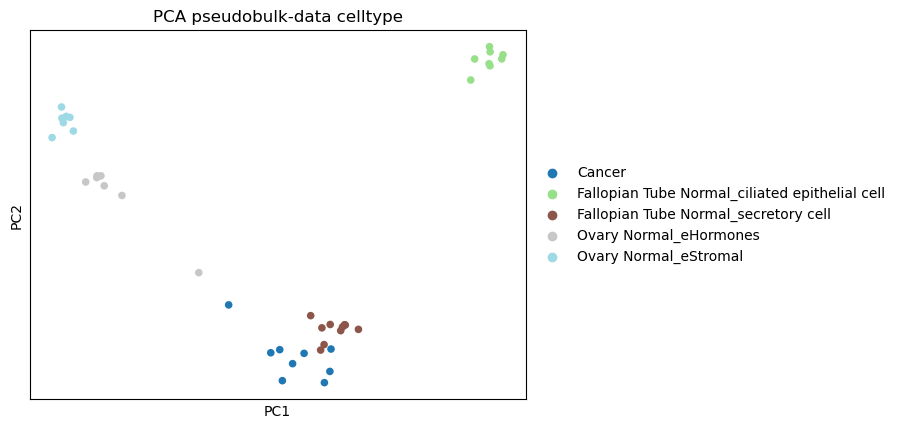

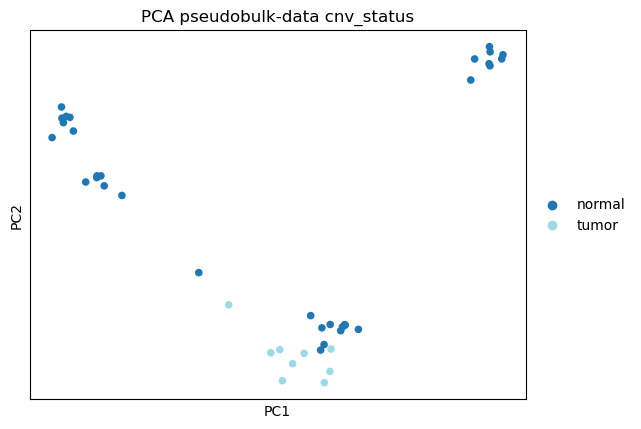

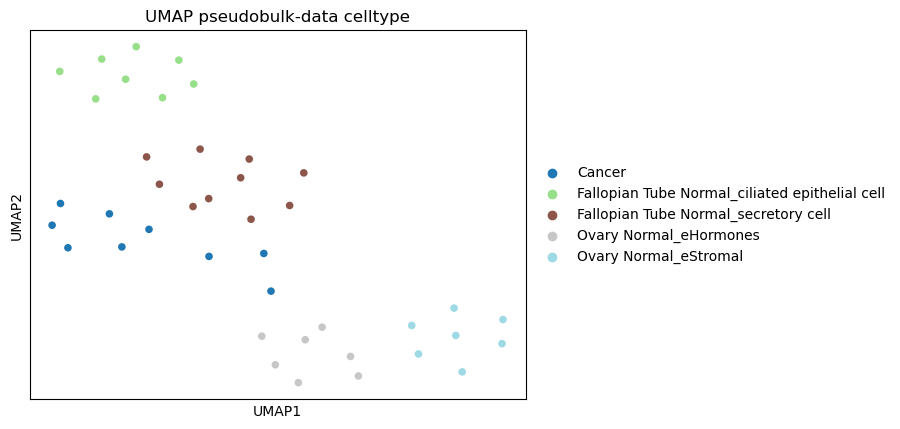

In [21]:
# PCA and UMAP
sc.pl.pca_scatter(
    adata_pseudobulk_normalized_log,
    title="PCA pseudobulk-data celltype",
    color="final_cell_annotation",
    size=120,
    palette="tab20",
)

sc.pl.pca_scatter(
    adata_pseudobulk_normalized_log,
    title="PCA pseudobulk-data cnv_status",
    color="cnv_status",
    size=120,
    palette="tab20",
)

sc.pl.umap(
    adata_pseudobulk_normalized_log,
    title="UMAP pseudobulk-data celltype",
    color="final_cell_annotation",
    size=120,
    palette="tab20",
)

# Analysis Not-Normalized Pseudobulk Data

... storing 'Sample' as categorical
... storing 'final_cell_annotation' as categorical
... storing 'dataset' as categorical
... storing 'cnv_status' as categorical


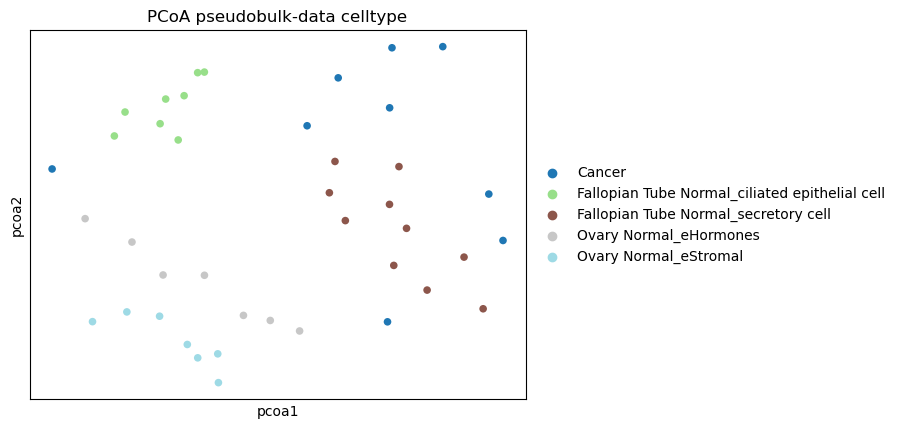

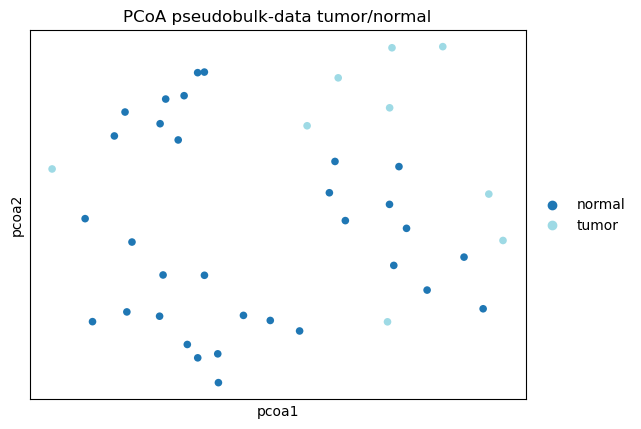

In [23]:
distance_matrix = cdist(adata_pseudobulk.X, adata_pseudobulk.X, metric="braycurtis")
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
pcoa_coordinates = mds.fit_transform(distance_matrix)
adata_pseudobulk.obsm["X_pcoa"] = pcoa_coordinates

sc.pl.embedding(
    adata_pseudobulk,
    basis="pcoa",
    title="PCoA pseudobulk-data celltype",
    color="final_cell_annotation",
    size=120,
    palette="tab20",
)

sc.pl.embedding(
    adata_pseudobulk,
    basis="pcoa",
    title="PCoA pseudobulk-data tumor/normal",
    color="cnv_status",
    size=120,
    palette="tab20",
)

# Analysis log1p Transformed Pseudobulk Data

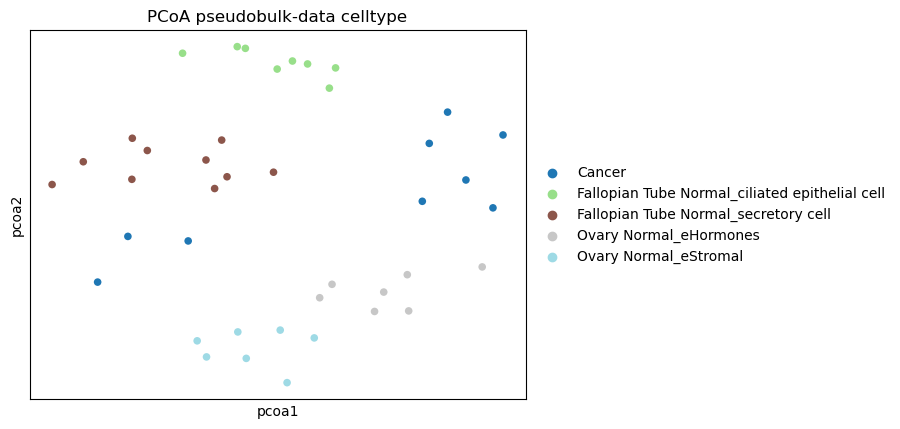

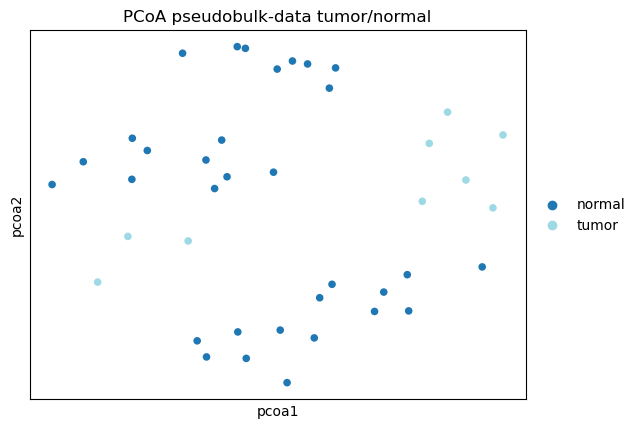

In [24]:
distance_matrix = cdist(
    adata_pseudobulk_normalized_log.X,
    adata_pseudobulk_normalized_log.X,
    metric="braycurtis",
)
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
pcoa_coordinates = mds.fit_transform(distance_matrix)
adata_pseudobulk_normalized_log.obsm["X_pcoa"] = pcoa_coordinates

sc.pl.embedding(
    adata_pseudobulk_normalized_log,
    basis="pcoa",
    title="PCoA pseudobulk-data celltype",
    color="final_cell_annotation",
    size=120,
    palette="tab20",
)

sc.pl.embedding(
    adata_pseudobulk_normalized_log,
    basis="pcoa",
    title="PCoA pseudobulk-data tumor/normal",
    color="cnv_status",
    size=120,
    palette="tab20",
)

# Find marker genes

In [25]:
# Dictionary to store marker genes
marker_genes = {}

In [26]:
adata_pseudobulk_normalized_log.obs["final_cell_annotation"].unique()

['Ovary Normal_eHormones', 'Ovary Normal_eStromal', 'Fallopian Tube Normal_secretory cell', 'Fallopian Tube Normal_ciliated epithelial cell', 'Cancer']
Categories (5, object): ['Cancer', 'Fallopian Tube Normal_ciliated epithelial cell', 'Fallopian Tube Normal_secretory cell', 'Ovary Normal_eHormones', 'Ovary Normal_eStromal']

In [27]:
exclude_values = ["Cancer"]
pseudobulk_no_cancer = adata_pseudobulk_normalized_log[
    ~adata_pseudobulk_normalized_log.obs["final_cell_annotation"].isin(exclude_values)
].copy()

pseudobulk_no_cancer.obs["final_cell_annotation"].unique()

['Ovary Normal_eHormones', 'Ovary Normal_eStromal', 'Fallopian Tube Normal_secretory cell', 'Fallopian Tube Normal_ciliated epithelial cell']
Categories (4, object): ['Fallopian Tube Normal_ciliated epithelial cell', 'Fallopian Tube Normal_secretory cell', 'Ovary Normal_eHormones', 'Ovary Normal_eStromal']

In [28]:
sc.tl.rank_genes_groups(
    pseudobulk_no_cancer,
    groupby="final_cell_annotation",
    method="wilcoxon",
    n_genes=50,
    use_raw=False,
)
all_markers = []
for ct in pseudobulk_no_cancer.obs["final_cell_annotation"].unique().categories:
    markers = (
        sc.get.rank_genes_groups_df(pseudobulk_no_cancer, group=ct)
        .head(50)["names"]
        .tolist()
    )
    all_markers.extend(markers)

In [29]:
desired_order = pseudobulk_no_cancer.obs["final_cell_annotation"].unique().to_list()
desired_order

['Ovary Normal_eHormones',
 'Ovary Normal_eStromal',
 'Fallopian Tube Normal_secretory cell',
 'Fallopian Tube Normal_ciliated epithelial cell']

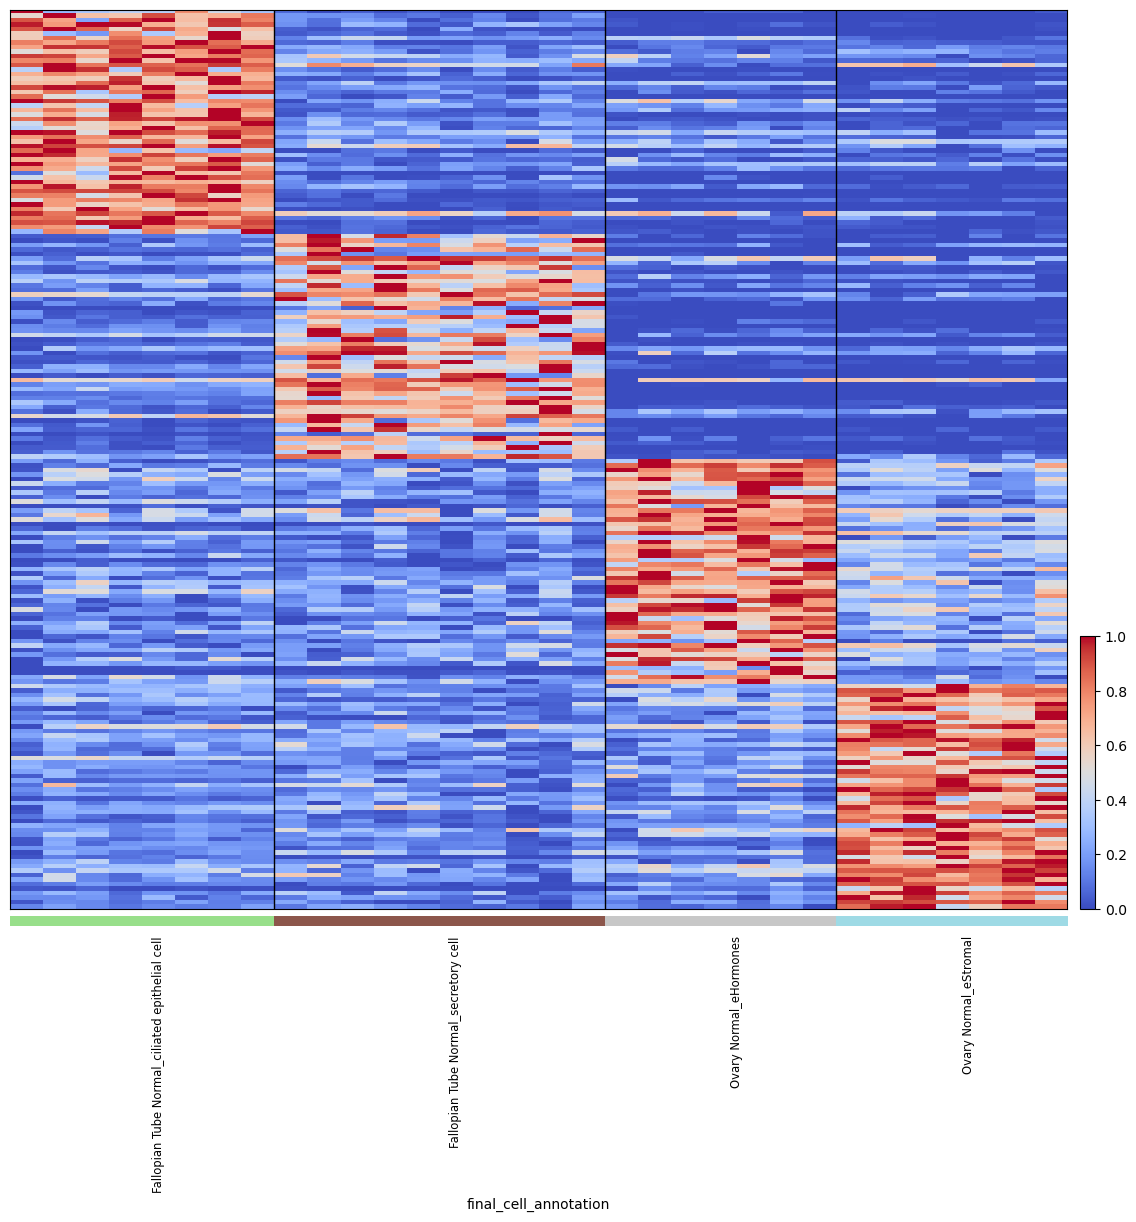

In [30]:
desired_order = [
    "Fallopian Tube Normal_ciliated epithelial cell",
    "Fallopian Tube Normal_secretory cell",
    "Ovary Normal_eHormones",
    "Ovary Normal_eStromal",
]

pseudobulk_no_cancer.obs["final_cell_annotation"] = pd.Categorical(
    pseudobulk_no_cancer.obs["final_cell_annotation"],
    categories=desired_order,
    ordered=True,
)

pseudobulk_no_cancer = pseudobulk_no_cancer[
    pseudobulk_no_cancer.obs["final_cell_annotation"].sort_values().index
].copy()

sc.pp.scale(pseudobulk_no_cancer, zero_center=True, max_value=10)

pseudobulk_no_cancer.obs["order"] = pseudobulk_no_cancer.obs[
    "final_cell_annotation"
].cat.codes
pseudobulk_no_cancer = pseudobulk_no_cancer[
    pseudobulk_no_cancer.obs["order"].sort_values().index
].copy()

sc.pl.heatmap(
    pseudobulk_no_cancer,
    var_names=all_markers,
    groupby="final_cell_annotation",
    figsize=(14, 12),
    cmap="coolwarm",
    dendrogram=False,
    swap_axes=True,
    use_raw=False,
    standard_scale="var",
)

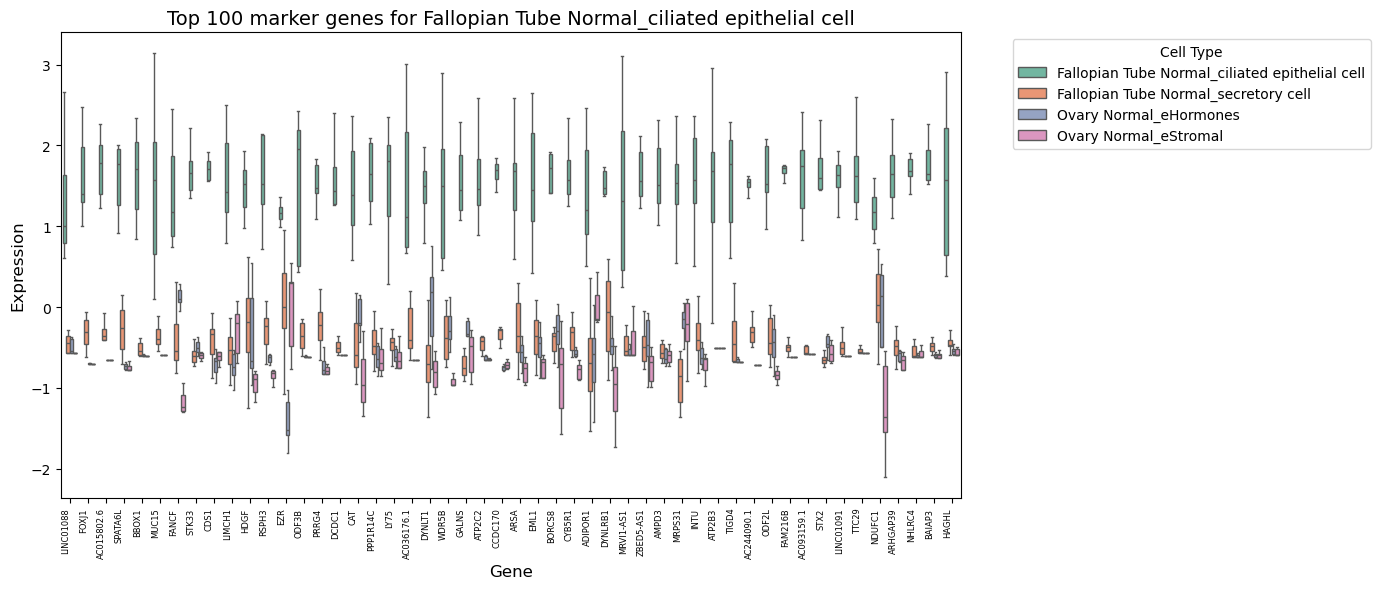

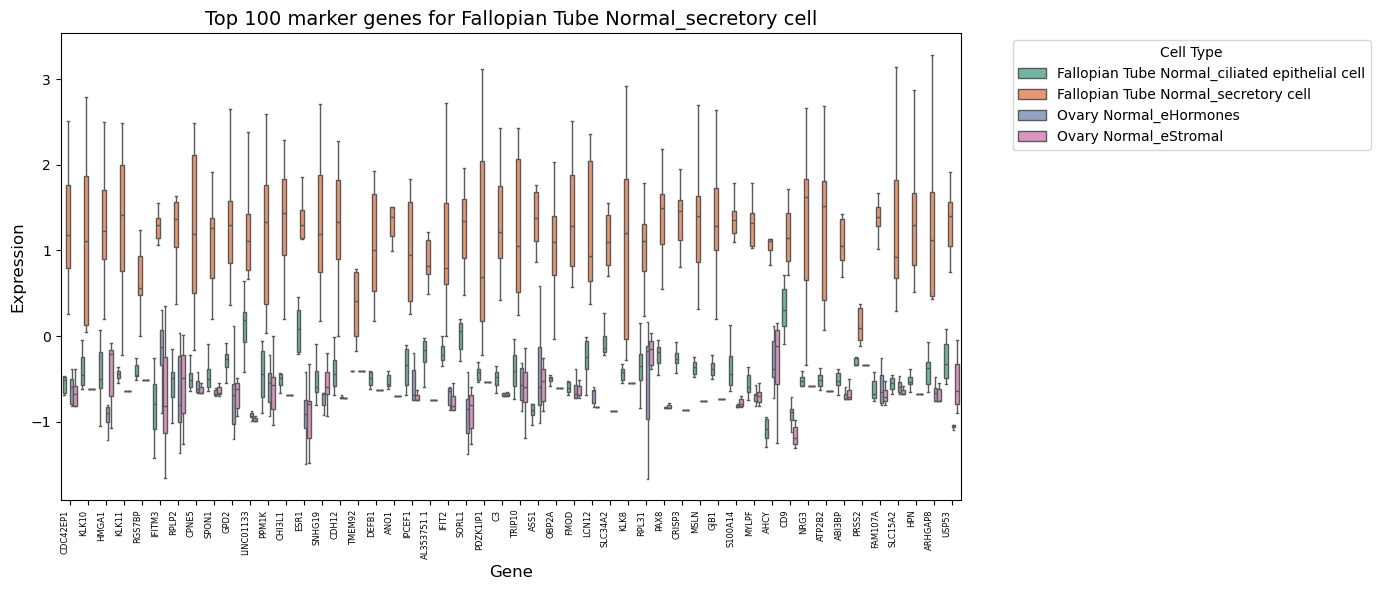

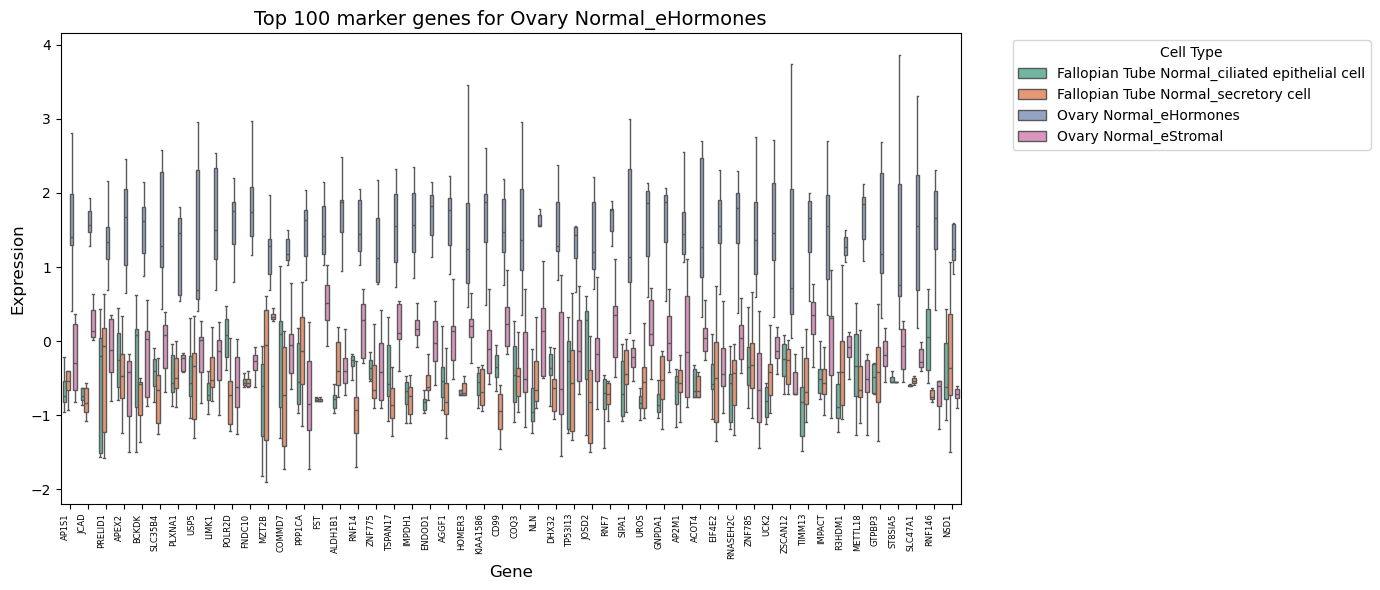

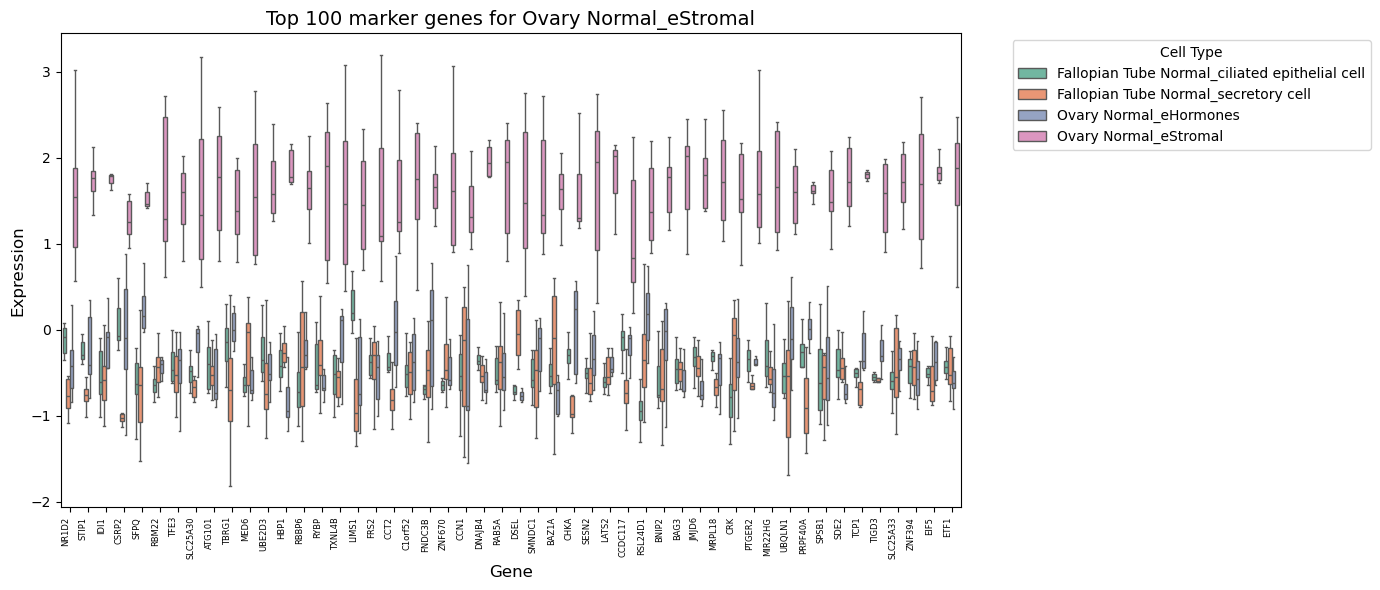

In [31]:
top_markers = 100
desired_order = [
    "Fallopian Tube Normal_ciliated epithelial cell",
    "Fallopian Tube Normal_secretory cell",
    "Ovary Normal_eHormones",
    "Ovary Normal_eStromal",
]

for group in desired_order:
    markers = (
        sc.get.rank_genes_groups_df(pseudobulk_no_cancer, group=group)
        .head(top_markers)["names"]
        .tolist()
    )
    adata_subset = pseudobulk_no_cancer[:, markers]
    expr_df = pd.DataFrame(adata_subset.X.toarray(), columns=markers)
    expr_df["cell_type"] = pseudobulk_no_cancer.obs["final_cell_annotation"].values

    expr_df_melted = expr_df.melt(
        id_vars="cell_type", var_name="gene", value_name="expression"
    )

    plt.figure(figsize=(14, 6))
    sns.boxplot(
        data=expr_df_melted,
        x="gene",
        y="expression",
        hue="cell_type",
        hue_order=desired_order,
        palette="Set2",
        showfliers=False,
    )

    plt.title(f"Top {top_markers} marker genes for {group}", fontsize=14)
    plt.xlabel("Gene", fontsize=12)
    plt.ylabel("Expression", fontsize=12)
    plt.xticks(rotation=90, ha="right", fontsize=6)
    plt.legend(title="Cell Type", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

In [32]:
adata_markers = adata_pseudobulk_normalized_log[
    :, adata_pseudobulk_normalized_log.var_names.isin(all_markers)
].copy()

# Check the result
print(f"Original shape: {adata_pseudobulk.shape}")
print(f"Filtered shape: {adata_markers.shape}")
print(f"Genes in filtered object: {adata_markers.var_names.tolist()}")

Original shape: (41, 36601)
Filtered shape: (41, 200)
Genes in filtered object: ['FNDC10', 'SPSB1', 'SLC25A33', 'SESN2', 'SFPQ', 'PDZK1IP1', 'DNAJB4', 'C1orf52', 'CCN1', 'ODF2L', 'S100A14', 'HDGF', 'LINC01133', 'UCK2', 'METTL18', 'ADIPOR1', 'CYB5R1', 'CHI3L1', 'FMOD', 'SDE2', 'ZNF670', 'AC093159.1', 'RPL31', 'LIMS1', 'PAX8', 'POLR2D', 'MZT2B', 'R3HDM1', 'PRPF40A', 'GPD2', 'LY75', 'EIF4E2', 'ATP2B2', 'RAB5A', 'NR1D2', 'FAM107A', 'RYBP', 'ABI3BP', 'SLC15A2', 'WDR5B', 'PLXNA1', 'RNF7', 'FNDC3B', 'AP2M1', 'SLC34A2', 'LIMCH1', 'LINC01088', 'CDS1', 'PPM1K', 'UBE2D3', 'USP53', 'LINC01091', 'INTU', 'NDUFC1', 'TTC29', 'TIGD4', 'CDH12', 'FST', 'RGS7BP', 'NLN', 'AGGF1', 'ETF1', 'RNF14', 'GNPDA1', 'RBM22', 'TSPAN17', 'NSD1', 'PRELID1', 'ZSCAN12', 'HMGA1', 'CPNE5', 'CRISP3', 'KIAA1586', 'COQ3', 'RNF146', 'PPP1R14C', 'CCDC170', 'ESR1', 'IPCEF1', 'DYNLT1', 'EZR', 'RSPH3', 'TCP1', 'MRPL18', 'LIMK1', 'ZNF394', 'AP1S1', 'HBP1', 'IMPDH1', 'SLC35B4', 'PRSS2', 'ZNF775', 'DEFB1', 'ARHGAP39', 'SPATA6L', 'ALD

In [33]:
# Bray-Curtis distance matrix calculation
distance_matrix = cdist(adata_markers.X, adata_markers.X, metric="braycurtis")

# PCoA using MDS (Multi-Dimensional Scaling)
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
pcoa_coordinates = mds.fit_transform(distance_matrix)

# Store PCoA results in AnnData object
adata_markers.obsm["X_pcoa"] = pcoa_coordinates

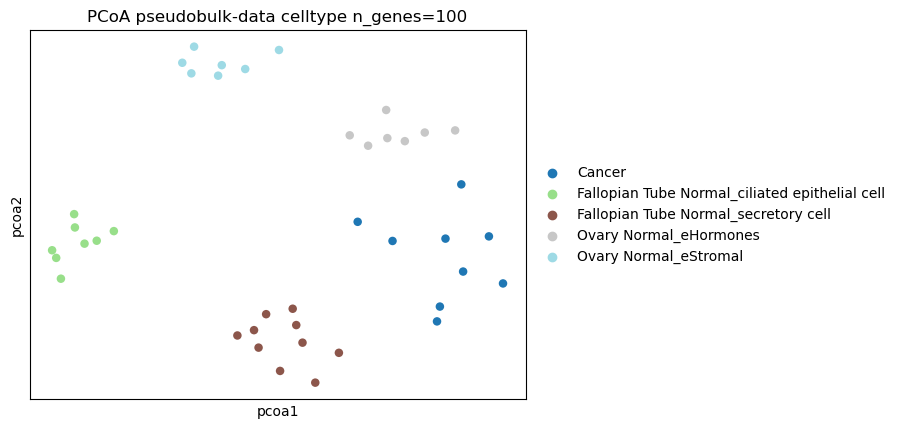

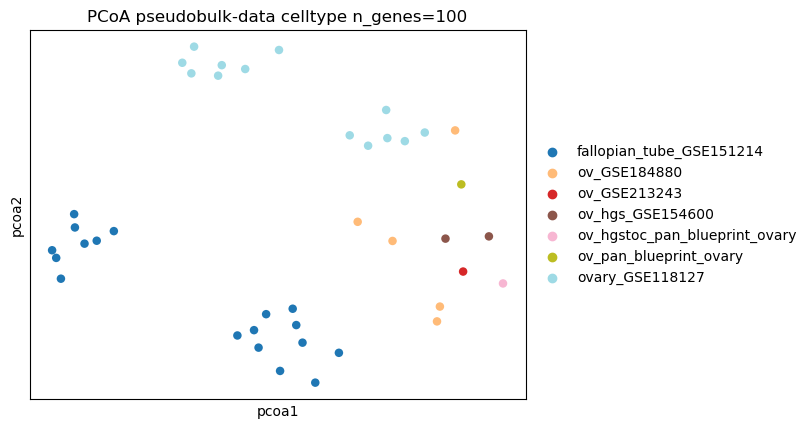

In [34]:
sc.pl.embedding(
    adata_markers,
    basis="pcoa",
    color=["final_cell_annotation"],
    title="PCoA pseudobulk-data celltype n_genes=100",
    size=150,
    palette="tab20",
    ncols=2,
)

sc.pl.embedding(
    adata_markers,
    basis="pcoa",
    color=["dataset"],
    title="PCoA pseudobulk-data celltype n_genes=100",
    size=150,
    palette="tab20",
    ncols=2,
)

In [35]:
adata_markers = adata_pseudobulk[:, adata_pseudobulk.var_names.isin(all_markers)].copy()

# Chech the result
print(f"Original shape: {adata_pseudobulk.shape}")
print(f"Filtered shape: {adata_markers.shape}")
print(f"Genes in filtered object: {adata_markers.var_names.tolist()}")

Original shape: (41, 36601)
Filtered shape: (41, 200)
Genes in filtered object: ['FNDC10', 'SPSB1', 'SLC25A33', 'SESN2', 'SFPQ', 'PDZK1IP1', 'DNAJB4', 'C1orf52', 'CCN1', 'ODF2L', 'S100A14', 'HDGF', 'LINC01133', 'UCK2', 'METTL18', 'ADIPOR1', 'CYB5R1', 'CHI3L1', 'FMOD', 'SDE2', 'ZNF670', 'AC093159.1', 'RPL31', 'LIMS1', 'PAX8', 'POLR2D', 'MZT2B', 'R3HDM1', 'PRPF40A', 'GPD2', 'LY75', 'EIF4E2', 'ATP2B2', 'RAB5A', 'NR1D2', 'FAM107A', 'RYBP', 'ABI3BP', 'SLC15A2', 'WDR5B', 'PLXNA1', 'RNF7', 'FNDC3B', 'AP2M1', 'SLC34A2', 'LIMCH1', 'LINC01088', 'CDS1', 'PPM1K', 'UBE2D3', 'USP53', 'LINC01091', 'INTU', 'NDUFC1', 'TTC29', 'TIGD4', 'CDH12', 'FST', 'RGS7BP', 'NLN', 'AGGF1', 'ETF1', 'RNF14', 'GNPDA1', 'RBM22', 'TSPAN17', 'NSD1', 'PRELID1', 'ZSCAN12', 'HMGA1', 'CPNE5', 'CRISP3', 'KIAA1586', 'COQ3', 'RNF146', 'PPP1R14C', 'CCDC170', 'ESR1', 'IPCEF1', 'DYNLT1', 'EZR', 'RSPH3', 'TCP1', 'MRPL18', 'LIMK1', 'ZNF394', 'AP1S1', 'HBP1', 'IMPDH1', 'SLC35B4', 'PRSS2', 'ZNF775', 'DEFB1', 'ARHGAP39', 'SPATA6L', 'ALD

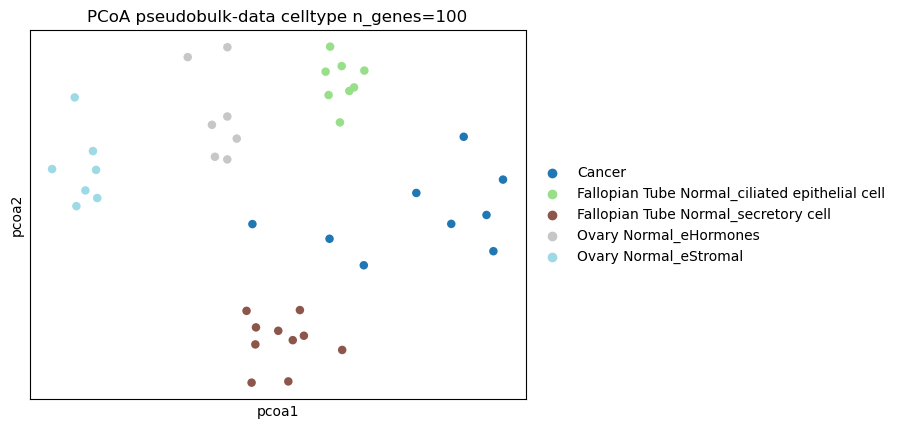

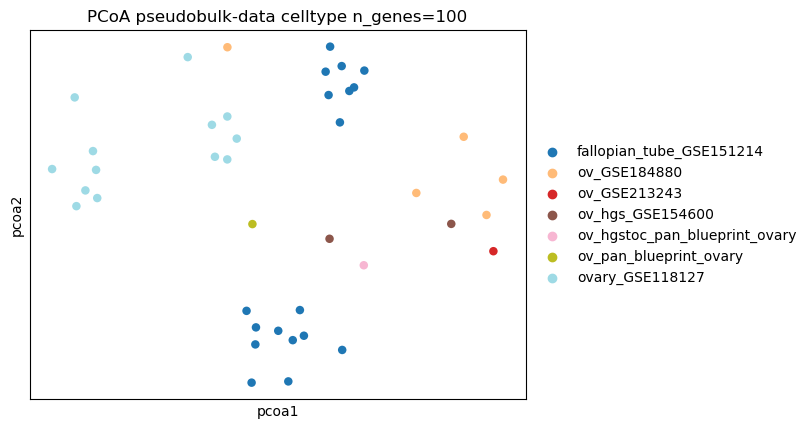

In [36]:
# Bray-Curtis distance matrix calculation
distance_matrix = cdist(adata_markers.X, adata_markers.X, metric="braycurtis")

# PCoA using MDS (Multi-Dimensional Scaling)
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
pcoa_coordinates = mds.fit_transform(distance_matrix)

# Store PCoA results in AnnData object
adata_markers.obsm["X_pcoa"] = pcoa_coordinates

sc.pl.embedding(
    adata_markers,
    basis="pcoa",
    color=["final_cell_annotation"],
    title="PCoA pseudobulk-data celltype n_genes=100",
    size=150,
    palette="tab20",
    ncols=2,
)

sc.pl.embedding(
    adata_markers,
    basis="pcoa",
    color=["dataset"],
    title="PCoA pseudobulk-data celltype n_genes=100",
    size=150,
    palette="tab20",
    ncols=2,
)

# For Deconvolution and ssGSEA

In [37]:
adata_pseudobulk.obs.final_cell_annotation.unique()

['Ovary Normal_eHormones', 'Ovary Normal_eStromal', 'Fallopian Tube Normal_secretory cell', 'Fallopian Tube Normal_ciliated epithelial cell', 'Cancer']
Categories (5, object): ['Cancer', 'Fallopian Tube Normal_ciliated epithelial cell', 'Fallopian Tube Normal_secretory cell', 'Ovary Normal_eHormones', 'Ovary Normal_eStromal']

In [38]:
print(adata_pseudobulk.X.sum(axis=1))

[10000.001  9999.999 10000.     9999.999 10000.001 10000.    10000.
  9999.999 10000.    10000.001 10000.     9999.999 10000.    10000.
 10000.    10000.    10000.     9999.999 10000.    10000.    10000.
 10000.    10000.001  9999.999 10000.    10000.001 10000.    10000.
 10000.     9999.999 10000.    10000.    10000.    10000.    10000.
  9999.999  9999.999  9999.999 10000.     9999.999 10000.   ]


In [39]:
# Dictionary to store marker genes
marker_genes = {}

In [40]:
adata_pseudobulk_normalized_log.obs["final_cell_annotation"].unique()
exclude_values = ["Cancer"]
pseudobulk_no_cancer = adata_pseudobulk_normalized_log[
    ~adata_pseudobulk_normalized_log.obs["final_cell_annotation"].isin(exclude_values)
].copy()

pseudobulk_no_cancer.obs["final_cell_annotation"].unique()
np.random.seed(42)
sc.tl.rank_genes_groups(
    pseudobulk_no_cancer,
    groupby="final_cell_annotation",
    method="wilcoxon",
    n_genes=100,
    use_raw=False,
)

all_markers = []
for ct in pseudobulk_no_cancer.obs["final_cell_annotation"].unique().categories:
    markers = (
        sc.get.rank_genes_groups_df(pseudobulk_no_cancer, group=ct)
        .head(100)["names"]
        .tolist()
    )
    all_markers.extend(markers)

In [41]:
adata_markers = adata_pseudobulk[:, adata_pseudobulk.var_names.isin(all_markers)].copy()

In [42]:
datasets_df = pd.DataFrame(
    adata_markers.X.T, index=adata_markers.var_names, columns=adata_markers.obs_names
)
datasets_df

,GSM3319036_Ovary Normal_eHormones,GSM3319036_Ovary Normal_eStromal,GSM3319040_Ovary Normal_eStromal,GSM3319041_Ovary Normal_eHormones,GSM3319041_Ovary Normal_eStromal,GSM3319042_Ovary Normal_eStromal,GSM3319043_Ovary Normal_eHormones,GSM3319043_Ovary Normal_eStromal,GSM3557960_Ovary Normal_eStromal,GSM3557970_Ovary Normal_eStromal,...,GSM4675273_Cancer,GSM4675277_Cancer,ov_GSE184880_GSM5599224_Ovary Normal_eHormones,ov_GSE184880_GSM5599225_Cancer,ov_GSE184880_GSM5599226_Cancer,ov_GSE184880_GSM5599230_Cancer,ov_GSE184880_GSM5599231_Cancer,ov_GSE213243_GSM6576367_Cancer,pan_blue_hgstoc_SOL012_Cancer,pan_blueprint_ovary_scrSOL004_Cancer
FNDC10,0.290044,0.033136,0.056179,0.308542,0.062202,0.018701,0.080335,0.000000,0.039735,0.041194,...,0.048077,0.036432,0.391779,0.182670,0.156930,0.156763,0.056633,0.133008,0.007541,0.024729
CFAP74,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008143,0.000000,0.000000,0.000000,...,0.010528,0.010741,0.000000,0.007000,0.006159,0.002330,0.003529,0.048351,0.000301,0.000000
PEX10,0.286582,0.207461,0.120883,0.224417,0.055928,0.067494,0.290385,0.125989,0.144763,0.165311,...,0.244179,0.267092,0.272300,0.145409,0.298515,0.246478,0.250896,0.153646,0.263205,0.007765
SPSB1,0.750631,1.575546,1.185878,0.284206,1.468578,1.225173,0.349588,0.947162,1.410723,1.151570,...,0.438567,0.468705,0.178340,0.184019,0.147959,0.362225,0.161979,0.089982,0.165074,0.091147
SLC25A33,0.239940,0.916228,0.747896,0.273582,0.980283,0.840757,0.212018,1.089101,1.199942,1.172281,...,0.513297,1.029878,0.299719,0.250677,0.439509,0.400230,0.251496,0.101318,0.309696,0.258843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VMA21,0.219799,0.190571,0.211402,0.409731,0.257130,0.187504,0.384514,0.217226,0.111338,0.136405,...,0.380422,0.522605,0.241330,0.348808,0.527743,0.561208,0.471819,0.569867,0.540865,0.728312
GABRE,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.298893,0.000000,0.000000,0.425963,0.016289,0.181070,1.155222,0.138763,0.131409,0.000000
ATP2B3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.002889,0.000000,0.000000,0.001726,0.036153,0.000536,0.013625
FLNA,2.105330,1.324950,0.702405,0.909158,0.639154,0.762892,1.541968,0.493907,0.790611,0.837112,...,2.488241,0.471065,2.516155,2.354553,0.865882,2.609947,2.007825,3.005847,1.299527,0.659515


In [43]:
type_column = "final_cell_annotation"
print(adata_markers.obs[type_column].unique())

['Ovary Normal_eHormones', 'Ovary Normal_eStromal', 'Fallopian Tube Normal_secretory cell', 'Fallopian Tube Normal_ciliated epithelial cell', 'Cancer']
Categories (5, object): ['Cancer', 'Fallopian Tube Normal_ciliated epithelial cell', 'Fallopian Tube Normal_secretory cell', 'Ovary Normal_eHormones', 'Ovary Normal_eStromal']


In [44]:
expr_df = pd.DataFrame(
    adata_markers.X.T,  # raws - genes, columns - samples
    index=adata_markers.var_names,
    columns=adata_markers.obs_names,
)
expr_df

,GSM3319036_Ovary Normal_eHormones,GSM3319036_Ovary Normal_eStromal,GSM3319040_Ovary Normal_eStromal,GSM3319041_Ovary Normal_eHormones,GSM3319041_Ovary Normal_eStromal,GSM3319042_Ovary Normal_eStromal,GSM3319043_Ovary Normal_eHormones,GSM3319043_Ovary Normal_eStromal,GSM3557960_Ovary Normal_eStromal,GSM3557970_Ovary Normal_eStromal,...,GSM4675273_Cancer,GSM4675277_Cancer,ov_GSE184880_GSM5599224_Ovary Normal_eHormones,ov_GSE184880_GSM5599225_Cancer,ov_GSE184880_GSM5599226_Cancer,ov_GSE184880_GSM5599230_Cancer,ov_GSE184880_GSM5599231_Cancer,ov_GSE213243_GSM6576367_Cancer,pan_blue_hgstoc_SOL012_Cancer,pan_blueprint_ovary_scrSOL004_Cancer
FNDC10,0.290044,0.033136,0.056179,0.308542,0.062202,0.018701,0.080335,0.000000,0.039735,0.041194,...,0.048077,0.036432,0.391779,0.182670,0.156930,0.156763,0.056633,0.133008,0.007541,0.024729
CFAP74,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008143,0.000000,0.000000,0.000000,...,0.010528,0.010741,0.000000,0.007000,0.006159,0.002330,0.003529,0.048351,0.000301,0.000000
PEX10,0.286582,0.207461,0.120883,0.224417,0.055928,0.067494,0.290385,0.125989,0.144763,0.165311,...,0.244179,0.267092,0.272300,0.145409,0.298515,0.246478,0.250896,0.153646,0.263205,0.007765
SPSB1,0.750631,1.575546,1.185878,0.284206,1.468578,1.225173,0.349588,0.947162,1.410723,1.151570,...,0.438567,0.468705,0.178340,0.184019,0.147959,0.362225,0.161979,0.089982,0.165074,0.091147
SLC25A33,0.239940,0.916228,0.747896,0.273582,0.980283,0.840757,0.212018,1.089101,1.199942,1.172281,...,0.513297,1.029878,0.299719,0.250677,0.439509,0.400230,0.251496,0.101318,0.309696,0.258843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VMA21,0.219799,0.190571,0.211402,0.409731,0.257130,0.187504,0.384514,0.217226,0.111338,0.136405,...,0.380422,0.522605,0.241330,0.348808,0.527743,0.561208,0.471819,0.569867,0.540865,0.728312
GABRE,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.298893,0.000000,0.000000,0.425963,0.016289,0.181070,1.155222,0.138763,0.131409,0.000000
ATP2B3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.002889,0.000000,0.000000,0.001726,0.036153,0.000536,0.013625
FLNA,2.105330,1.324950,0.702405,0.909158,0.639154,0.762892,1.541968,0.493907,0.790611,0.837112,...,2.488241,0.471065,2.516155,2.354553,0.865882,2.609947,2.007825,3.005847,1.299527,0.659515


In [45]:
sample_types = adata_markers.obs[type_column]
signatures_df = expr_df.T.groupby(sample_types).mean().T
signatures_df

final_cell_annotation,Cancer,Fallopian Tube Normal_ciliated epithelial cell,Fallopian Tube Normal_secretory cell,Ovary Normal_eHormones,Ovary Normal_eStromal
FNDC10,0.089198,0.009460,0.007910,0.296992,0.035878
CFAP74,0.009882,0.686123,0.016502,0.001847,0.000000
PEX10,0.208576,0.137956,0.116411,0.315643,0.126833
SPSB1,0.234406,0.374577,0.424593,0.407505,1.280662
SLC25A33,0.394994,0.169694,0.210704,0.235006,0.992355
...,...,...,...,...,...
VMA21,0.516850,0.806336,0.219060,0.307419,0.187368
GABRE,0.260845,0.003574,0.046819,0.000000,0.000000
ATP2B3,0.006103,0.096712,0.000222,0.000000,0.000000
FLNA,1.751378,0.236541,0.355157,2.217117,0.793005


In [47]:
exclude_values = ["Cancer"]
pseudobulk_no_cancer = adata_pseudobulk_normalized_log[
    ~adata_pseudobulk_normalized_log.obs["final_cell_annotation"].isin(exclude_values)
].copy()

pseudobulk_no_cancer.obs["final_cell_annotation"].unique()

['Ovary Normal_eHormones', 'Ovary Normal_eStromal', 'Fallopian Tube Normal_secretory cell', 'Fallopian Tube Normal_ciliated epithelial cell']
Categories (4, object): ['Fallopian Tube Normal_ciliated epithelial cell', 'Fallopian Tube Normal_secretory cell', 'Ovary Normal_eHormones', 'Ovary Normal_eStromal']

In [48]:
sc.tl.rank_genes_groups(
    pseudobulk_no_cancer,
    groupby="final_cell_annotation",
    method="wilcoxon",
    n_genes=100,
    use_raw=False,
)

all_markers = {}
for ct in pseudobulk_no_cancer.obs["final_cell_annotation"].cat.categories:
    markers = (
        sc.get.rank_genes_groups_df(pseudobulk_no_cancer, group=ct)
        .head(100)["names"]
        .tolist()
    )
    all_markers[ct] = markers

In [49]:
all_markers

{'Fallopian Tube Normal_ciliated epithelial cell': ['LINC01088',
  'FOXJ1',
  'AC015802.6',
  'SPATA6L',
  'BBOX1',
  'MUC15',
  'FANCF',
  'STK33',
  'CDS1',
  'LIMCH1',
  'HDGF',
  'RSPH3',
  'EZR',
  'ODF3B',
  'PRRG4',
  'DCDC1',
  'CAT',
  'PPP1R14C',
  'LY75',
  'AC036176.1',
  'DYNLT1',
  'WDR5B',
  'GALNS',
  'ATP2C2',
  'CCDC170',
  'ARSA',
  'EML1',
  'BORCS8',
  'CYB5R1',
  'ADIPOR1',
  'DYNLRB1',
  'MRVI1-AS1',
  'ZBED5-AS1',
  'AMPD3',
  'MRPS31',
  'INTU',
  'ATP2B3',
  'TIGD4',
  'AC244090.1',
  'ODF2L',
  'FAM216B',
  'AC093159.1',
  'STX2',
  'LINC01091',
  'TTC29',
  'NDUFC1',
  'ARHGAP39',
  'NHLRC4',
  'BAIAP3',
  'HAGHL',
  'MBD3L1',
  'PCDH7',
  'TMEM17',
  'TMPRSS2',
  'PLAC4',
  'PRRT3',
  'SMARCA2',
  'SATB1',
  'IFT140',
  'SLC6A6',
  'TRAPPC9',
  'EFHB',
  'ZHX1',
  'LRRC6',
  'AC106820.3',
  'ANXA13',
  'LCA5L',
  'GET1',
  'FAM166B',
  'IQANK1',
  'MAPK15',
  'GIPR',
  'MORN3',
  'TTLL7',
  'AC127070.2',
  'PNMA8C',
  'UNC119B',
  'DNAI1',
  'C9orf24',
  'W